In [1]:
import os
import json
from recordtype import recordtype
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters
import pathlib

import dadrah.util.data_processing as dapr
import dadrah.selection.qr_workflow as qrwf

## params

In [2]:
params_t = recordtype('Parameters','qr_run_n, env_n, sig_sample_id, sig_xsec, poly_order, kfold_n')
params = params_t(qr_run_n = 402, env_n=4020, sig_sample_id='GtoWW35naReco', sig_xsec=0, poly_order=5, kfold_n=5) 
quantiles = [0.3, 0.5, 0.7, 0.9]
out_qr_run_n = 43

## paths

In [3]:
def make_polys_json_path(qr_poly_run_n):
    envelope_dir = '/eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_'+str(qr_poly_run_n)+'/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope'
    if params.env_n is not None:
        envelope_dir = envelope_dir + '_' + str(params.env_n)
    polys_json_path = os.path.join(envelope_dir, 'polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json')
    pathlib.Path(envelope_dir).mkdir(parents=True, exist_ok=True)
    return polys_json_path

In [4]:
envelope_dir = '/eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_'+str(params.qr_run_n)+'/sig_GtoWW35naReco/xsec_'+str(params.sig_xsec)+'/loss_rk5_05/envelope'
if params.env_n is not None:
    envelope_dir = envelope_dir + '_' + str(params.env_n)
polys_json_path = os.path.join(envelope_dir, 'polynomials_allQ_allFolds_'+ params.sig_sample_id + '_xsec_' + str(params.sig_xsec) + '.json')
fig_dir = '../fig/poly_analysis/'

## read envelope

In [5]:
bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

envelope_per_fold = {}
for k in range(params.kfold_n+1):
    envelope_json_path = os.path.join(envelope_dir, 'cut_stats_allQ_fold'+str(k+1)+'_'+ params.sig_sample_id + '_xsec_' + str(params.sig_xsec) + '.json')
    ff = open(envelope_json_path)
    envelope_per_fold['fold_{}'.format(k+1)] = json.load(ff)
    
x_shift = np.asarray(envelope_per_fold['fold_1'][str(quantiles[0])])[0,bin_idx]

In [6]:
x_shift

1200.0

# fitting functions

## generic fitting

In [7]:
def fit_poly_from_envelope(fit_fun, uncert_fun, degree, envelope, quantiles, *fit_args):
    
    bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

    fits = {}

    for qq in quantiles:

        qq_key = str(qq)
        env_qq = np.asarray(envelope[qq_key])

        x      = env_qq[:,bin_idx]
        y      = env_qq[:,mu_idx]
        uncert = uncert_fun(env_qq)        
        cc = fit_fun(degree, x, y, uncert, *fit_args)
        
        fits[qq] = np.poly1d(cc)

    return fits

In [8]:
def fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params, *fit_args):
    
    poly_fits_per_fold = {}
    
    for k in range(params.kfold_n+1):
        poly_fits = fit_poly_from_envelope(fit_fun, uncert_fun, degree, envelope_per_fold['fold_{}'.format(k+1)], quantiles, *fit_args)
        poly_fits_per_fold['fold_{}'.format(k+1)] = poly_fits
    
    return poly_fits_per_fold

## poly1d weighted fit

In [9]:
# simple numpy polynomial fit
def fit_poly1d_coeff(degree, x, y, uncert):
    return np.polyfit(x, y, degree, w=1./uncert) # weights: inverse uncertainty

## curve fit

In [10]:
def poly_wrap(x, *p):
    return np.poly1d(p)(x)

In [11]:
# scipy curve fit
def fit_curve_coeff(degree, x, y, uncert):
    cc, _ = sp.optimize.curve_fit(poly_wrap, x, y, np.ones(degree), sigma=uncert)
    return cc

## lm fit

In [12]:
def residual(params, x, y, uncert, x_shift):
    y_hat = np.poly1d(params)(x-x_shift) # shift first bin to zero & fix bias
    return (y - y_hat)/uncert

In [13]:
def fit_lm(degree, x, y, uncert, x_shift):
    
    params_lmfit = Parameters()
    for d in range(degree-1):
        params_lmfit.add('c'+str(d), value=1)
    # add fixed bias value
    params_lmfit.add('bias', value=y[0], vary=False)
    
    return minimize(residual, params_lmfit, args=(x, y, uncert, x_shift))

In [14]:
def fit_lm_coeff(degree, x, y, uncert, x_shift):
    
    out = fit_lm(degree, x, y, uncert, x_shift)
    
    return list(out.params.valuesdict().values())

## uncertainty functions

In [15]:
eps = 1e-6

In [16]:
def uncertainty_rmse(envelope, fix_point_n=0):
    sigma = envelope[:,rmse_idx]
    sigma[:fix_point_n] = eps
    return sigma

In [17]:
def uncertainty_yerr(envelope, fix_point_n=0):
    y = envelope[:,mu_idx]
    sigma = np.asarray([y-envelope[:,min_idx], envelope[:,max_idx]-y])
    sigma[:,:fix_point_n] = eps
    return sigma

In [18]:
def uncertainty_stddev(envelope, fix_point_n=0):
    sigma = (envelope[:,max_idx]-envelope[:,min_idx])/4
    sigma[:fix_point_n] = eps
    return sigma

In [19]:
def uncertainty_minmax(envelope, fix_point_n=0):
    sigma = envelope[:,max_idx]-envelope[:,min_idx]
    sigma[:fix_point_n] = eps
    return sigma

In [20]:
def uncertainty_updown(envelope, fix_point_n=0):
    y      = envelope[:,mu_idx]
    y_down = np.fabs(y-envelope[:,min_idx])
    y_up   = np.fabs(y-envelope[:,max_idx])
    sigma = y_down+y_up
    sigma[:fix_point_n] = eps
    return sigma

In [25]:
fp_n = 0
ee = np.asarray(envelope_per_fold['fold_1'][str(0.3)])
u_f = lambda e : uncertainty_updown(e,fp_n)
u = u_f(ee)

In [26]:
u

array([0.01348031, 0.00999653, 0.00738871, 0.01032531, 0.01546597,
       0.02240086, 0.03100586, 0.04032898, 0.04949057, 0.05776572,
       0.06494963, 0.07136488, 0.07768345, 0.0846827 , 0.09311891,
       0.1032269 , 0.11540985, 0.12910461, 0.14419079, 0.15972662,
       0.1750679 , 0.18942738, 0.20209122, 0.21248436, 0.22025251,
       0.22511911, 0.2270031 , 0.22606134, 0.2225256 , 0.21676111,
       0.20920849, 0.20029736, 0.19055891, 0.18040657, 0.18330383,
       0.18863487, 0.19713831, 0.20591402, 0.23173857, 0.2587738 ,
       0.28681326, 0.3157773 , 0.34571743])

In [27]:
fp_n = 3
u = u_f(ee)

In [28]:
u

array([1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.03253126e-02,
       1.54659748e-02, 2.24008560e-02, 3.10058594e-02, 4.03289795e-02,
       4.94905710e-02, 5.77657223e-02, 6.49496317e-02, 7.13648796e-02,
       7.76834488e-02, 8.46827030e-02, 9.31189060e-02, 1.03226900e-01,
       1.15409851e-01, 1.29104614e-01, 1.44190788e-01, 1.59726620e-01,
       1.75067902e-01, 1.89427376e-01, 2.02091217e-01, 2.12484360e-01,
       2.20252514e-01, 2.25119114e-01, 2.27003098e-01, 2.26061344e-01,
       2.22525597e-01, 2.16761112e-01, 2.09208488e-01, 2.00297356e-01,
       1.90558910e-01, 1.80406570e-01, 1.83303833e-01, 1.88634872e-01,
       1.97138309e-01, 2.05914021e-01, 2.31738567e-01, 2.58773804e-01,
       2.86813259e-01, 3.15777302e-01, 3.45717430e-01])

## plotting functions

In [29]:
def plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, plot_name_suffix, x_shift=0):
    
    bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)
    
    for q in quantiles:
        
        fig, axs = plt.subplots(2, params.kfold_n+1, figsize=(30,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
        
        for k, ax, ax_ratio in zip(range(params.kfold_n+1), axs.flat, axs.flat[int(len(axs.flat)/2):]):
            
            envelope_q = np.asarray(envelope_per_fold['fold_{}'.format(k+1)][str(q)])
            poly_fit_q = poly_fits_per_fold['fold_{}'.format(k+1)][q]
            
            x = envelope_q[:,bin_idx]
            y = envelope_q[:,mu_idx]
            y_hat = poly_fit_q(x-x_shift)
            yerr = [y-envelope_q[:,min_idx], envelope_q[:,max_idx]-y]
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', ms=1.5, zorder=1)
            ax.plot(x, y_hat, c='r',lw=1, zorder=2)
            ax.set_title('fold {}'.format(k+1))
            
            ax_ratio.plot(x, (y-y_hat)/uncertainty_minmax(envelope_q), 'o', ms=1.7)
            ax_ratio.grid(True, which='major', axis='y')
            #ax_ratio.set_ylim([0.995,1.005])
        
        for ax in axs.flat:
            ax.label_outer()
        
        plt.suptitle('quantile {}'.format(q))
        plt.savefig(fig_dir+'poly_fit_q{}_{}.pdf'.format(int(q*100), plot_name_suffix))
        plt.show()

In [30]:
np.set_printoptions(precision=5, suppress=True)

# poly1d fits

In [31]:
def compute_poly1d_fits(degree, envelope_per_fold, quantiles, params):
    fit_fun = fit_poly1d_coeff
    uncert_fun = uncertainty_minmax
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

### degree = 5 

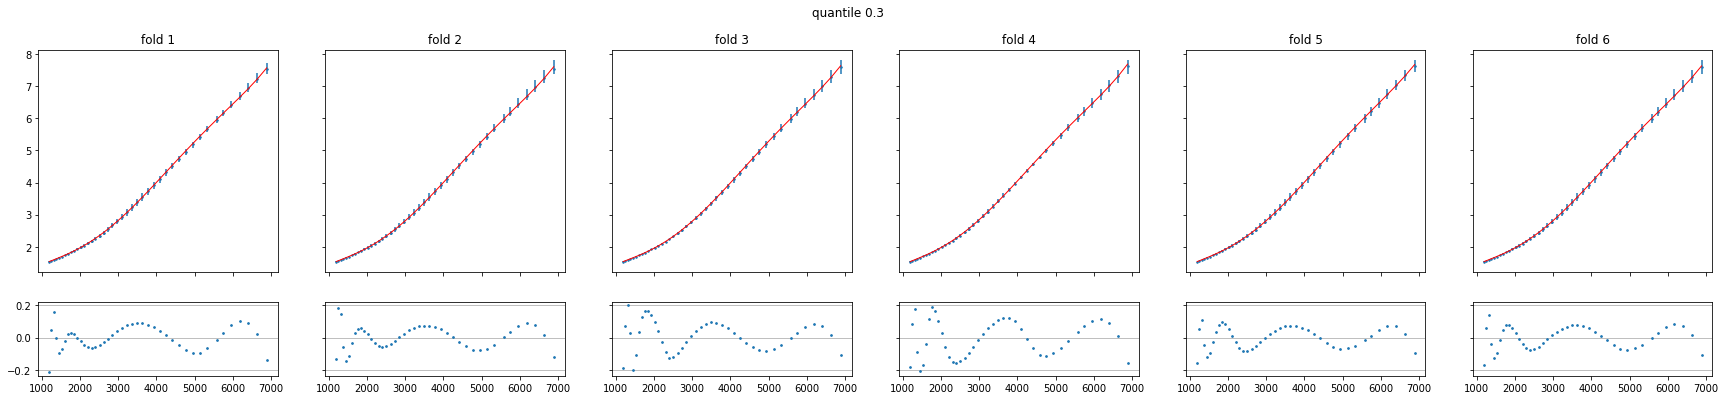

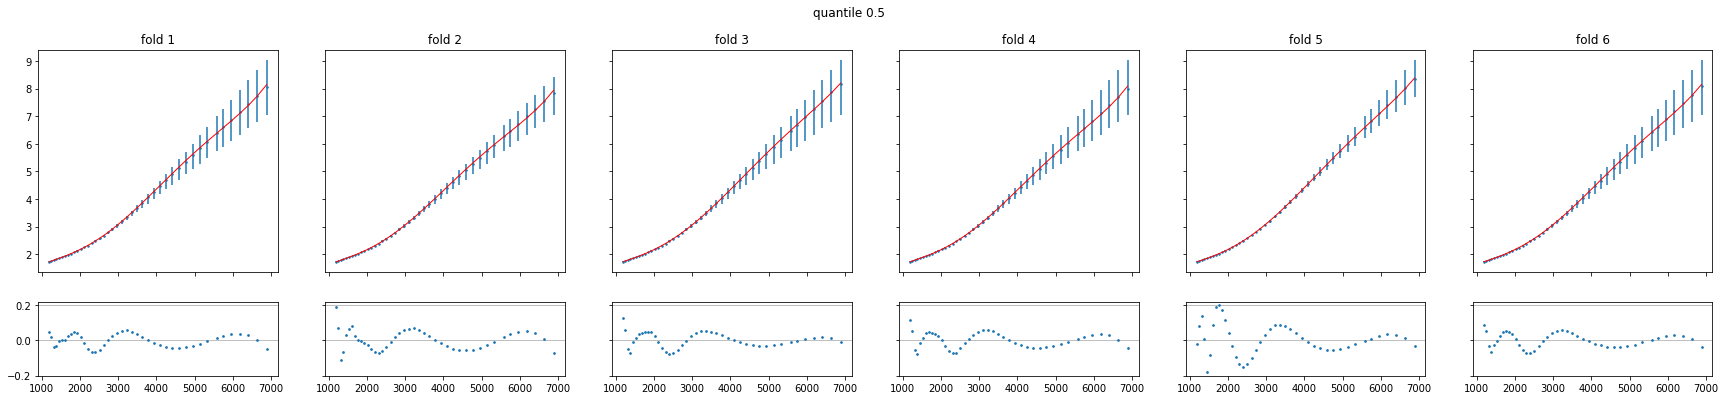

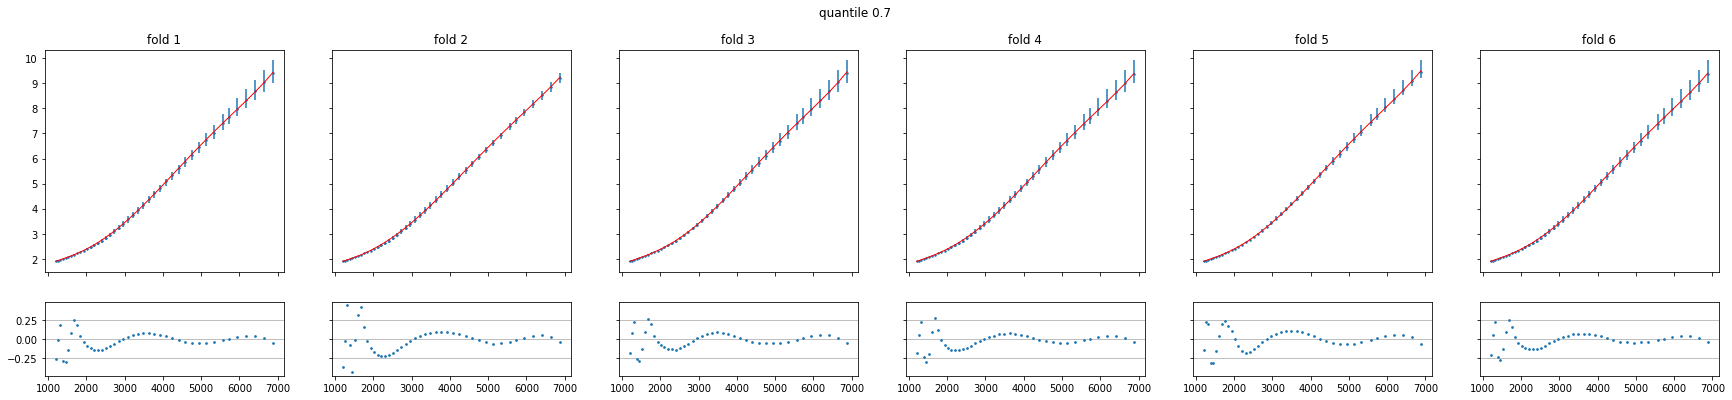

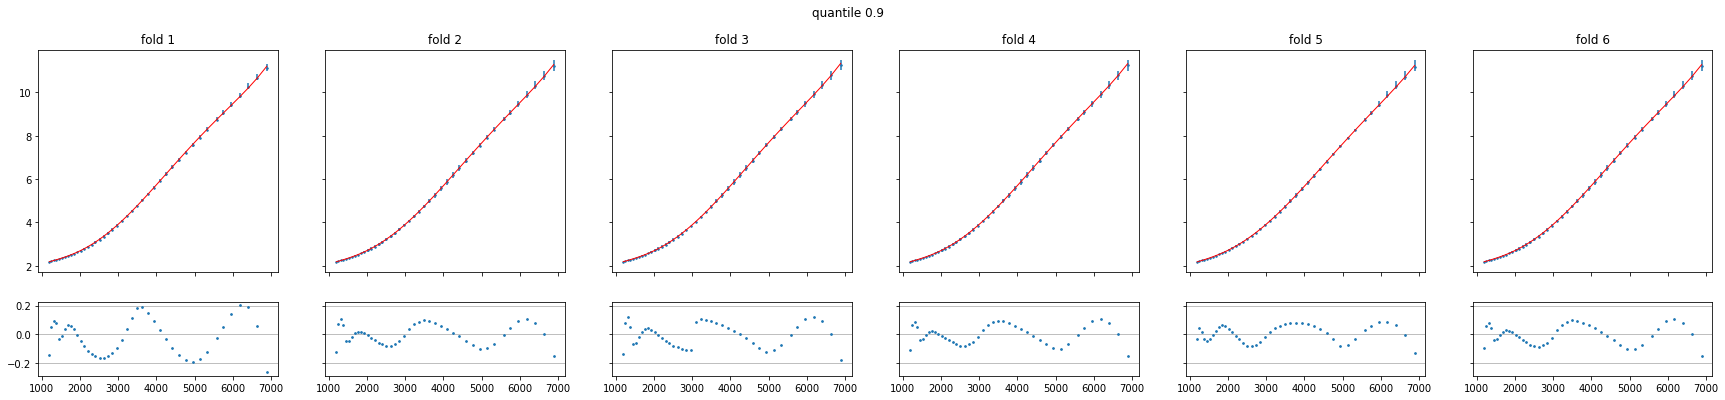

In [32]:
deg = 5
poly_fits_per_fold = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params) # per kfold -> per quantile
plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, 'np_polyfit_ord'+str(deg))

In [33]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), poly_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_43/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope_4020/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


### degree = 11

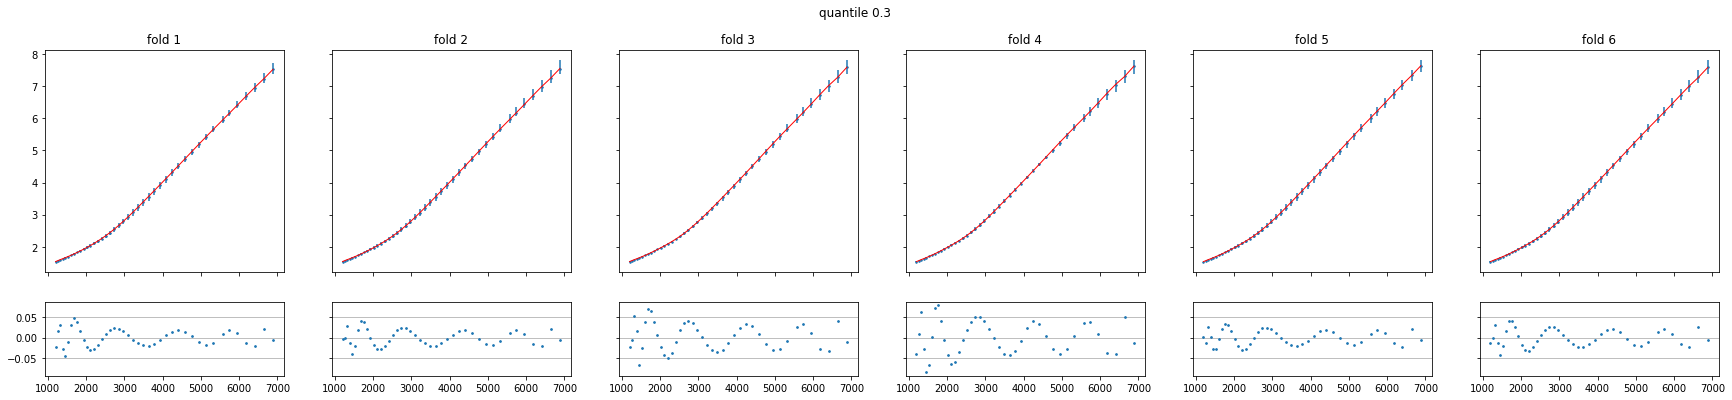

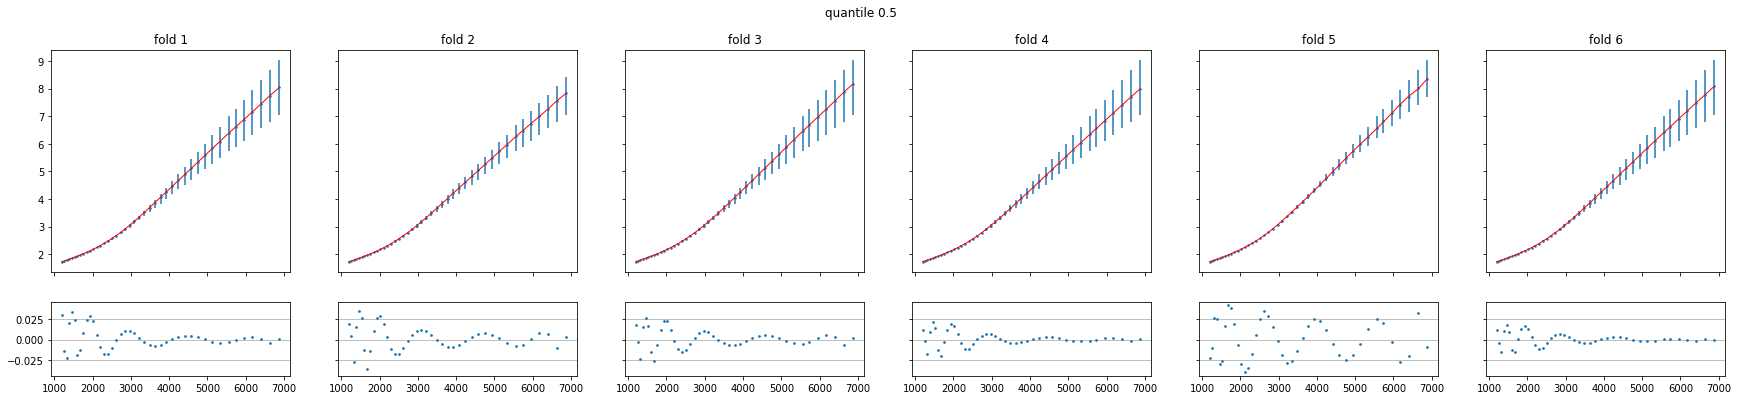

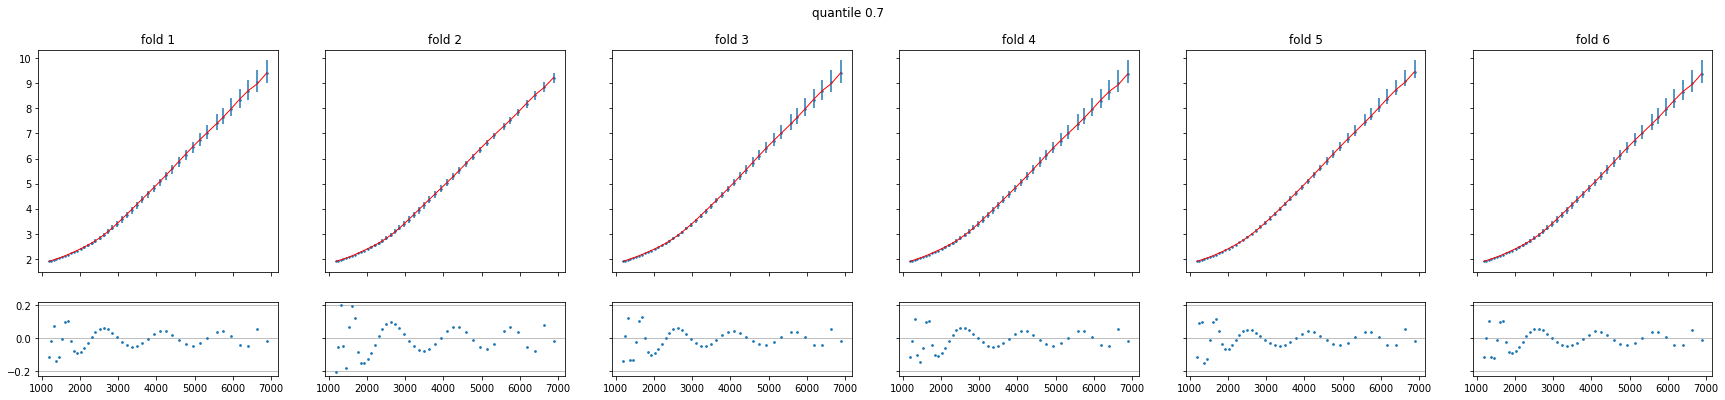

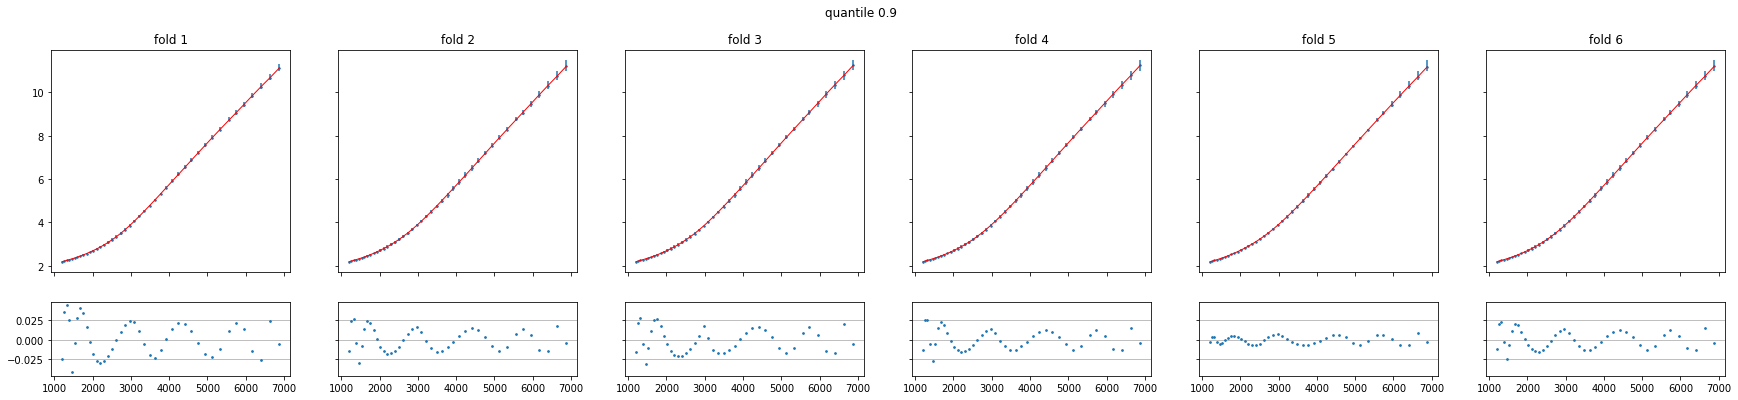

In [34]:
deg = 11
poly_fits_per_fold = compute_poly1d_fits(deg, envelope_per_fold, quantiles, params)
plot_poly_fits(envelope_per_fold, poly_fits_per_fold, quantiles, params, 'np_polyfit_ord'+str(deg))

# curve_fit

In [35]:
def compute_curve_fits(degree, envelope_per_fold, quantiles, params, fix_point_n=3):
    fit_fun = fit_curve_coeff
    uncert_fun = lambda e: uncertainty_updown(e, fix_point_n)
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params)

## fixed points = 3

In [36]:
fix_point_n = 3

### degree = 7

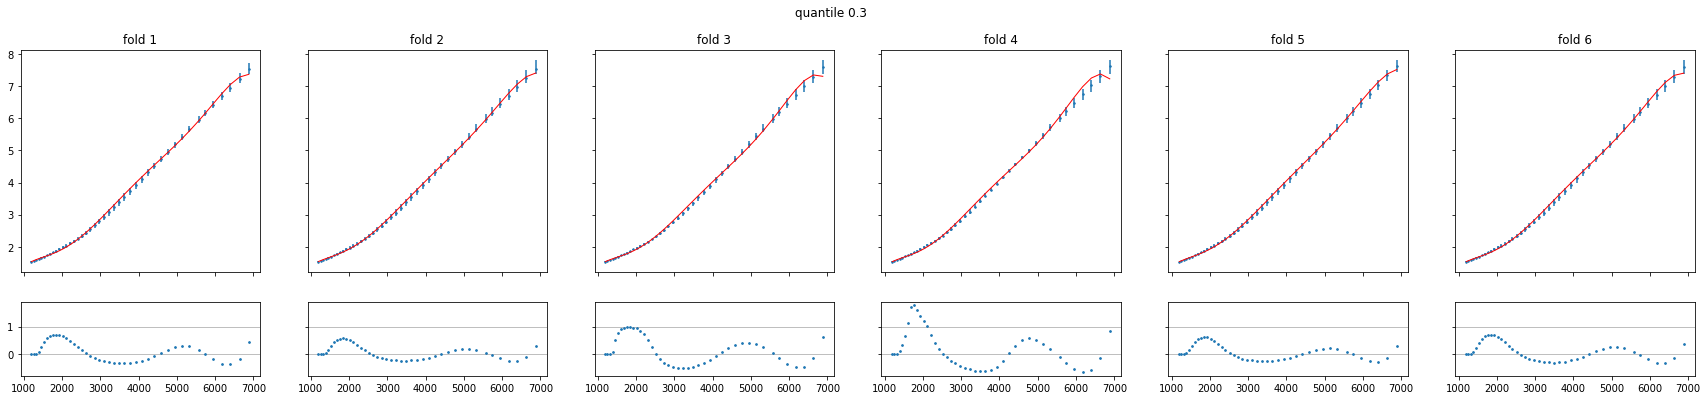

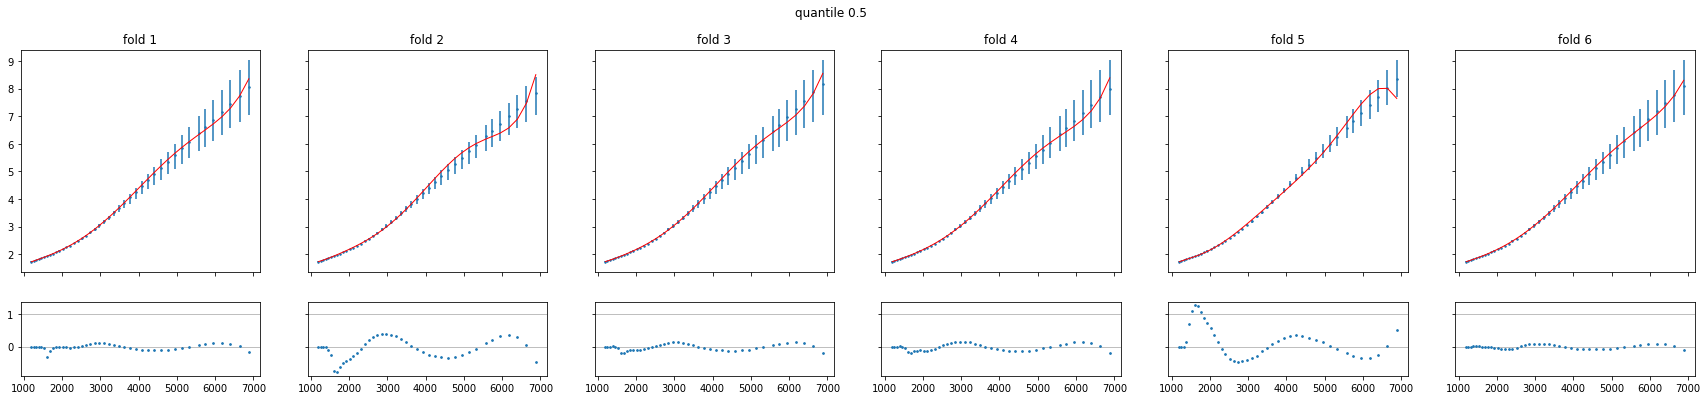

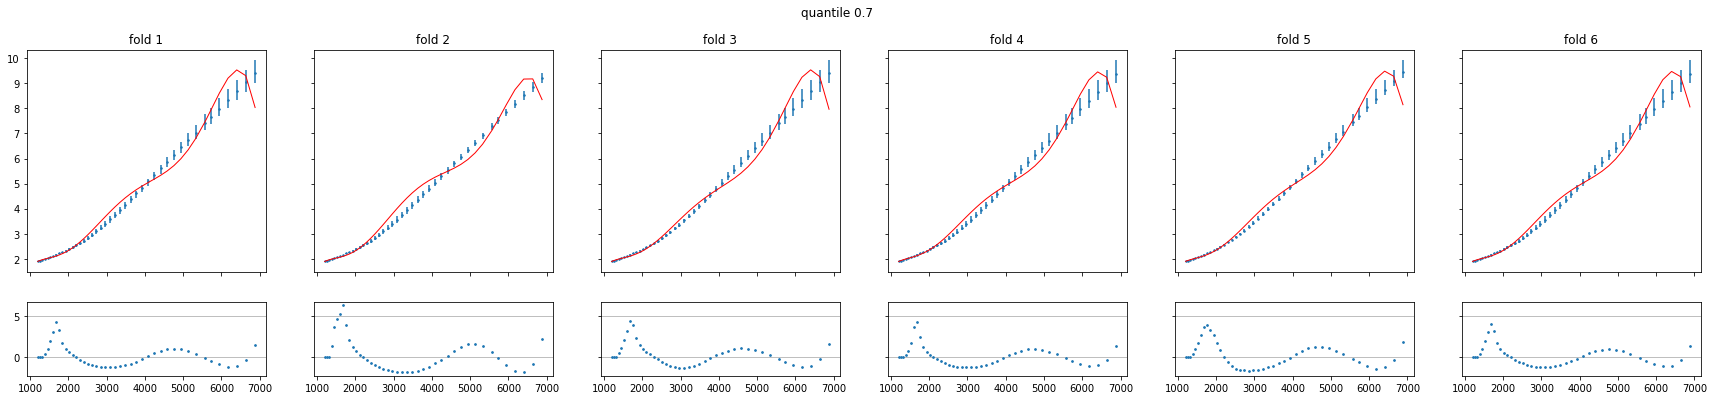

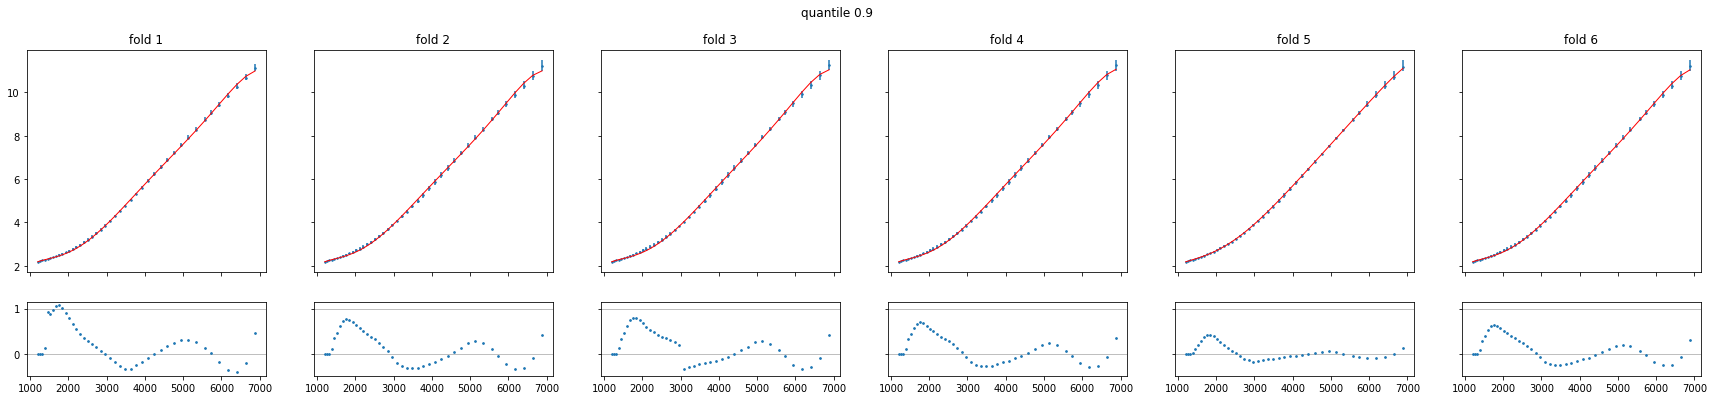

In [37]:
deg = 7
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params, fix_point_n)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg)+'_fixp_'+str(fix_point_n))

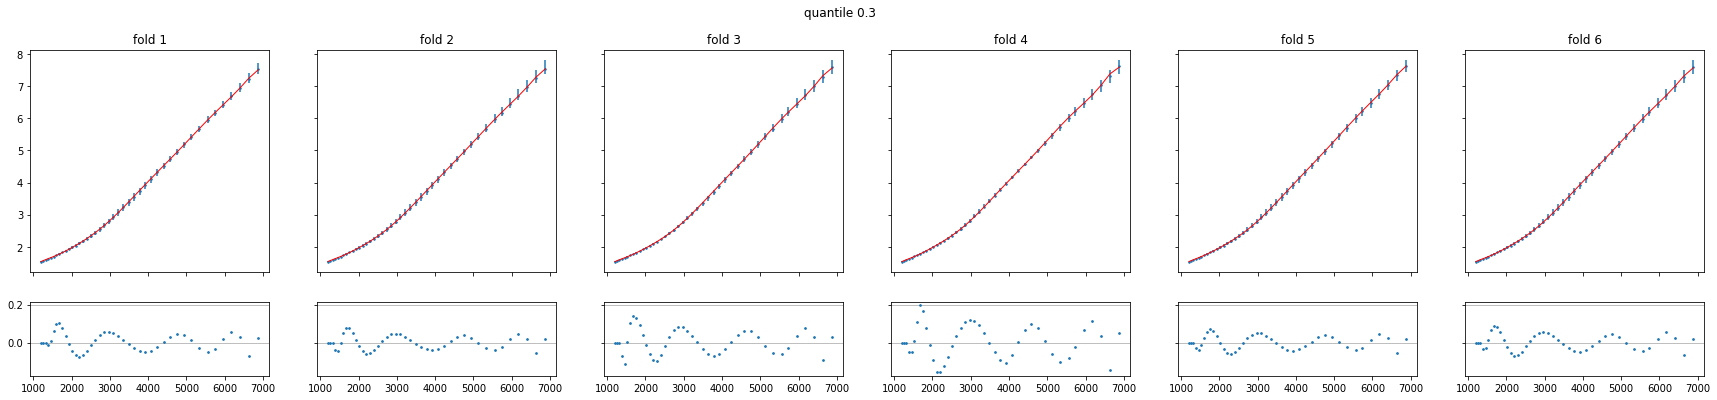

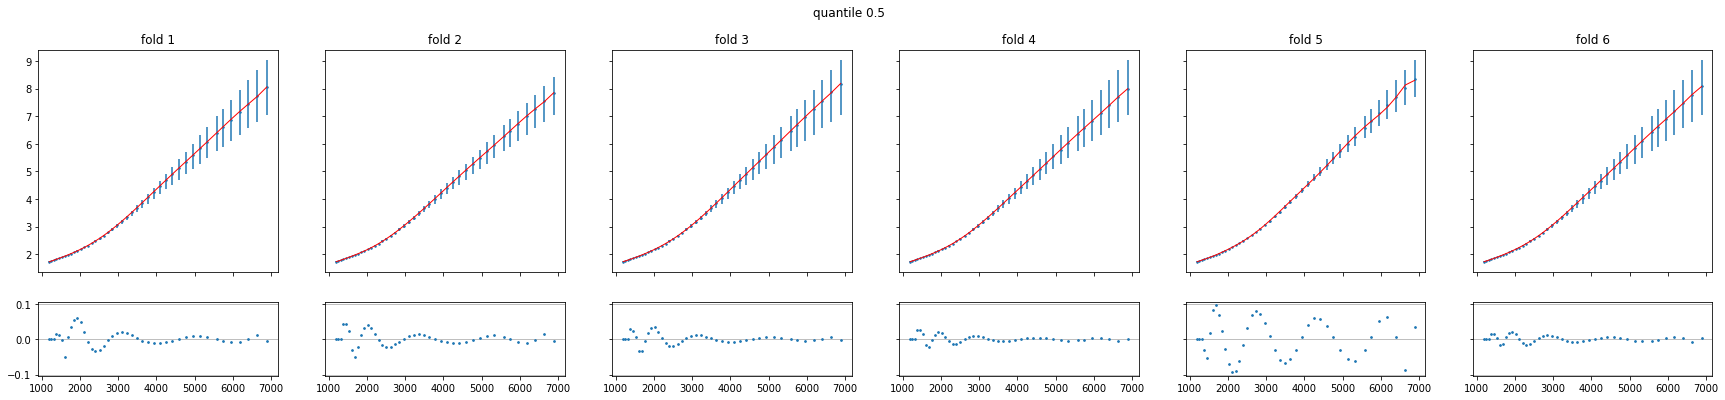

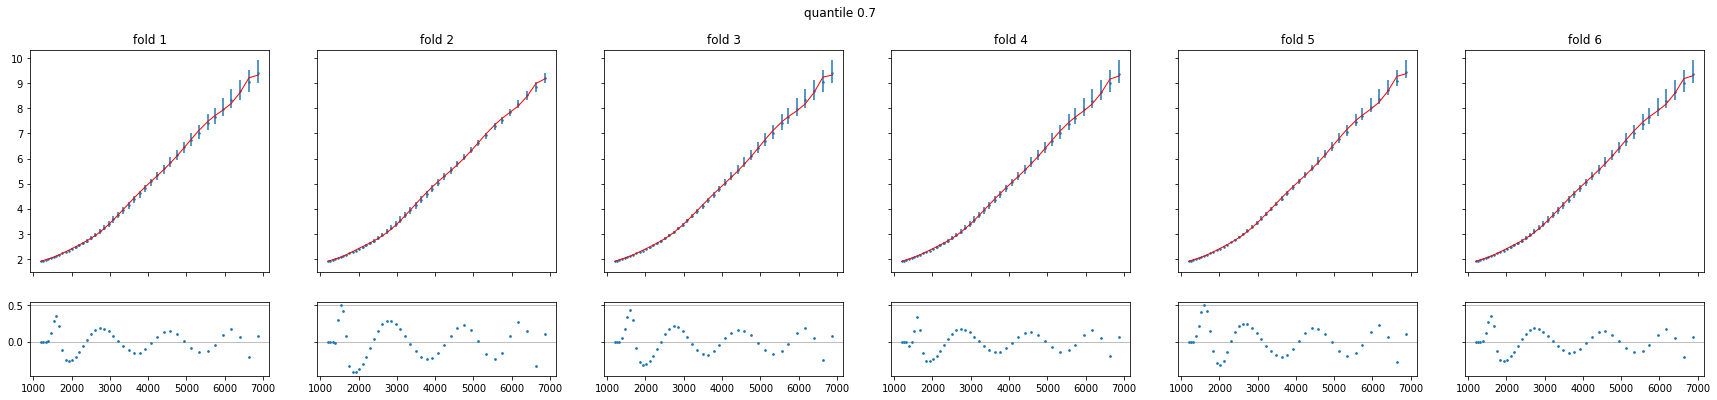

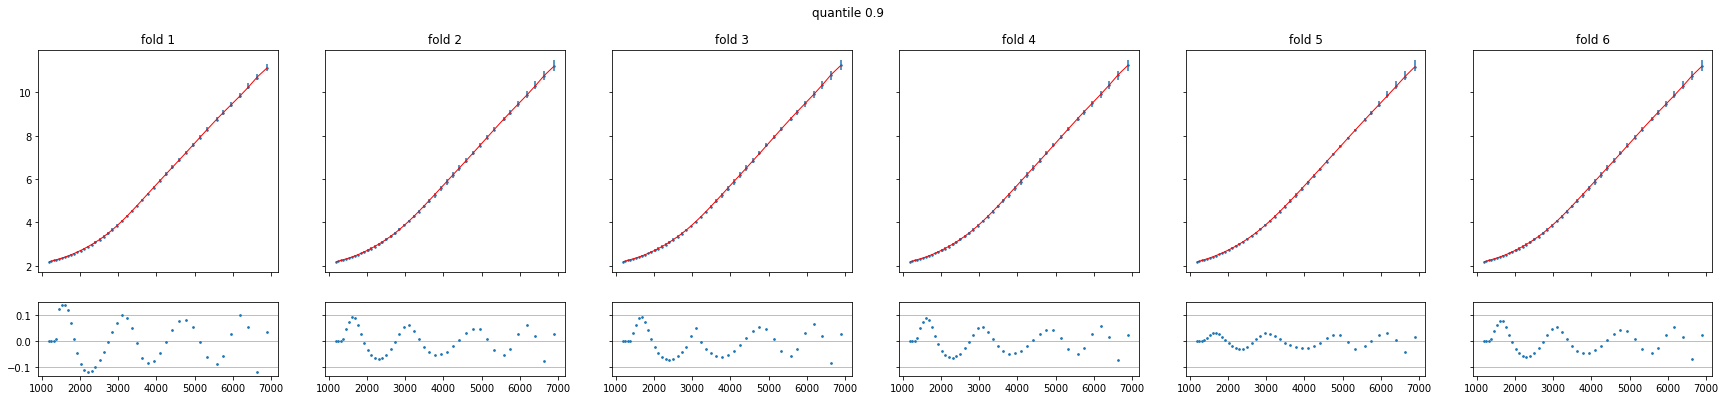

In [38]:
deg = 11
curve_fits_per_fold = compute_curve_fits(deg, envelope_per_fold, quantiles, params, fix_point_n)
plot_poly_fits(envelope_per_fold, curve_fits_per_fold, quantiles, params, 'np_curvefit_ord'+str(deg)+'_fixp_'+str(fix_point_n))

In [39]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n+1
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), curve_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_44/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope_4020/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


## lmfit

In [94]:
def compute_lm_fits(degree, envelope_per_fold, quantiles, params, x_shift):
    fit_fun = fit_lm_coeff
    uncert_fun = uncertainty_yerr #uncertainty_minmax #uncertainty_stddev #uncertainty_yerr #uncertainty_rmse #uncertainty_updown
    return fit_poly_from_envelope_forall_folds(fit_fun, uncert_fun, degree, envelope_per_fold, quantiles, params, x_shift)

### degree = 5

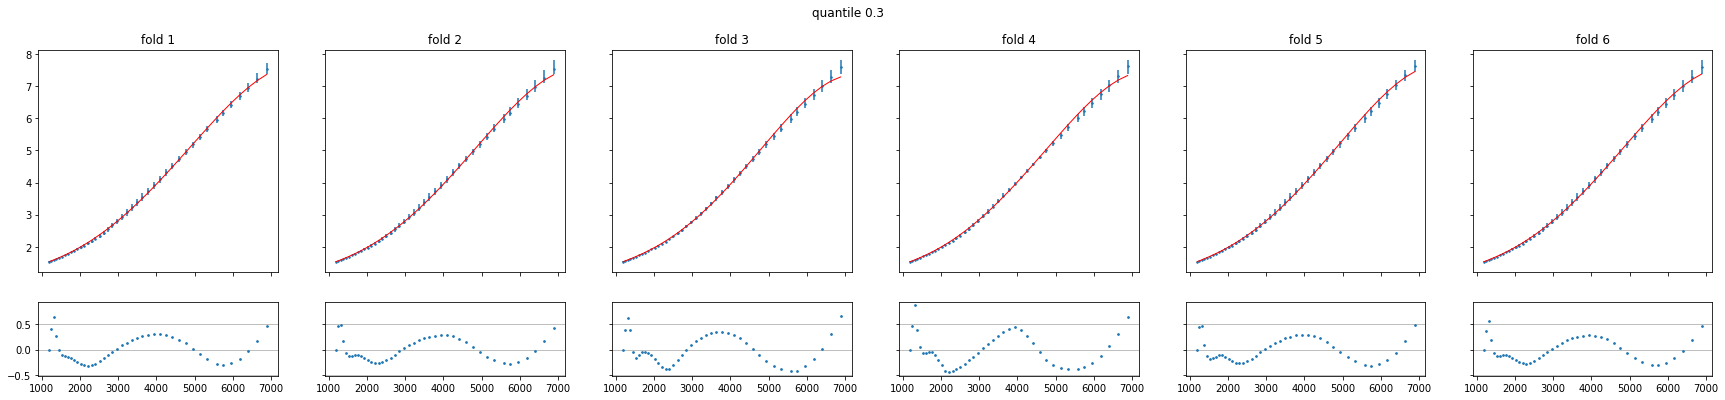

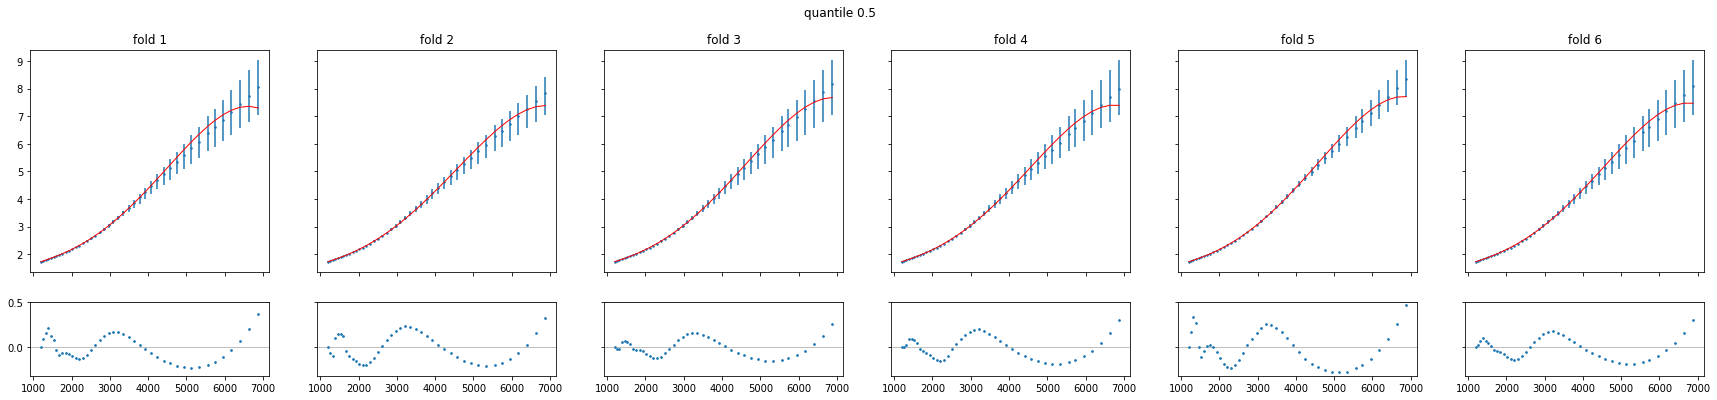

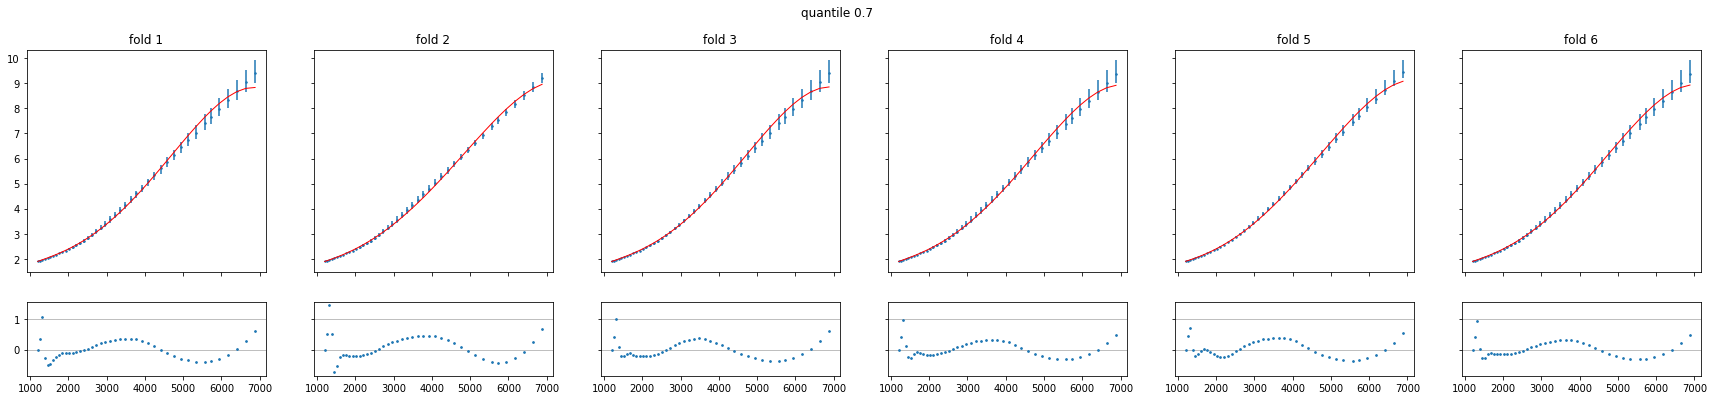

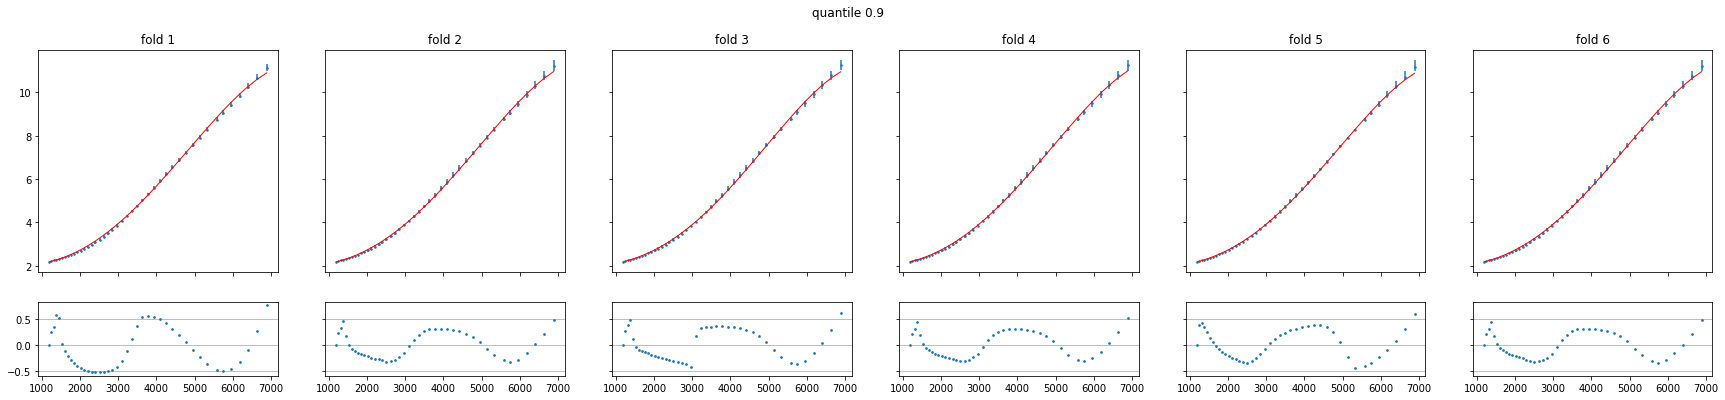

In [95]:
deg = 5
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params, x_shift)
plot_poly_fits(envelope_per_fold, lm_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg), x_shift)

In [96]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n+2
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), lm_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_45/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope_4020/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


### degree = 7

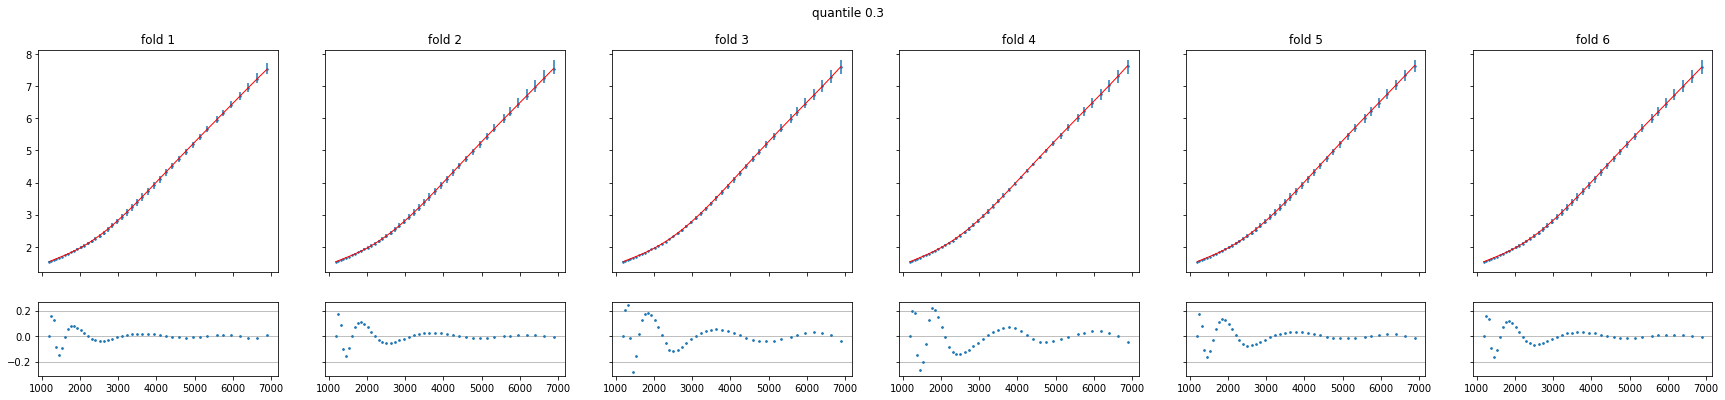

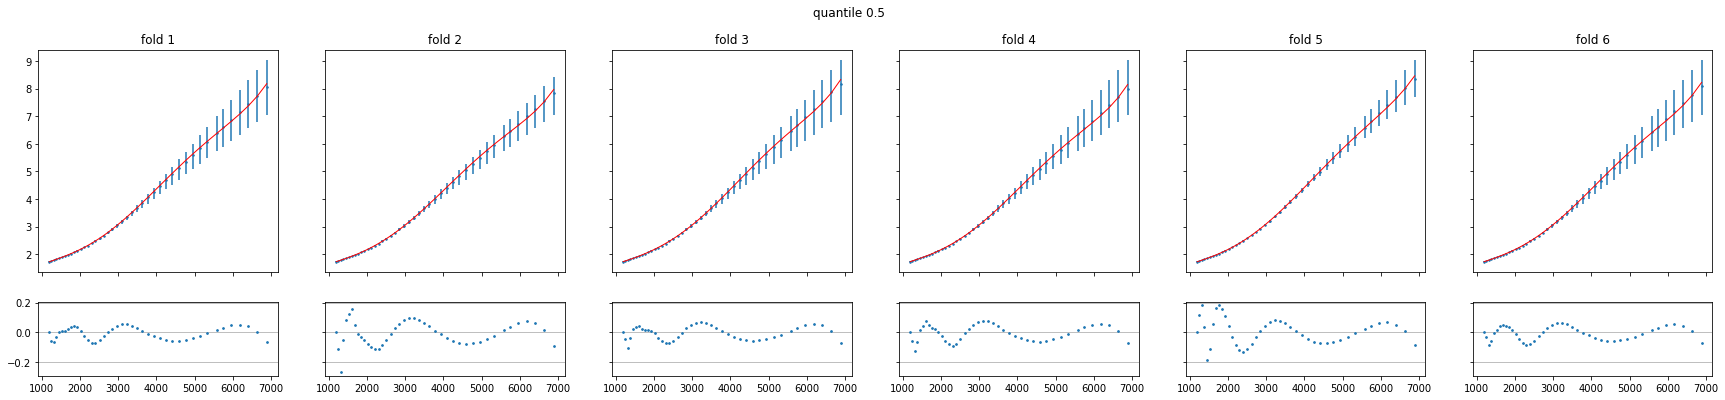

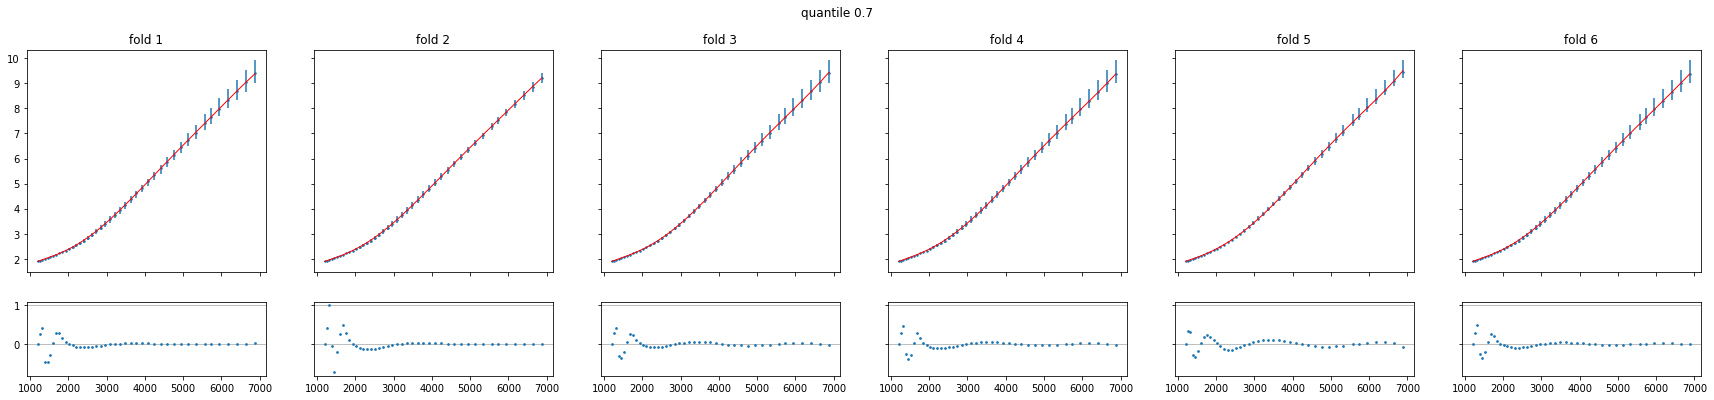

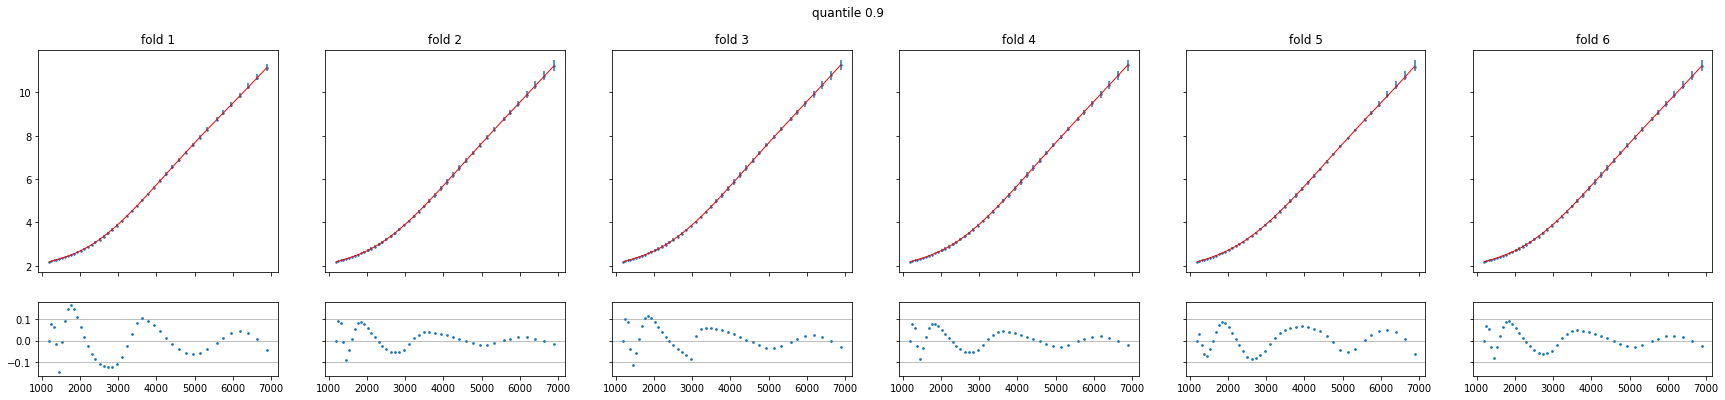

In [97]:
deg = 7
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params, x_shift)
plot_poly_fits(envelope_per_fold, lm_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg), x_shift)

### degree = 11

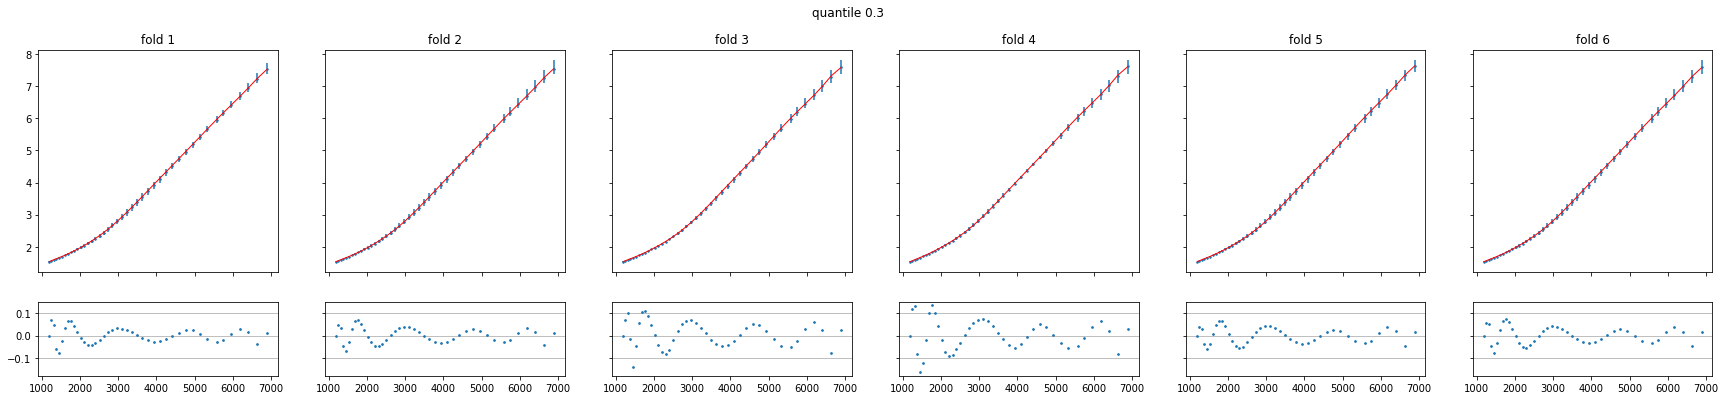

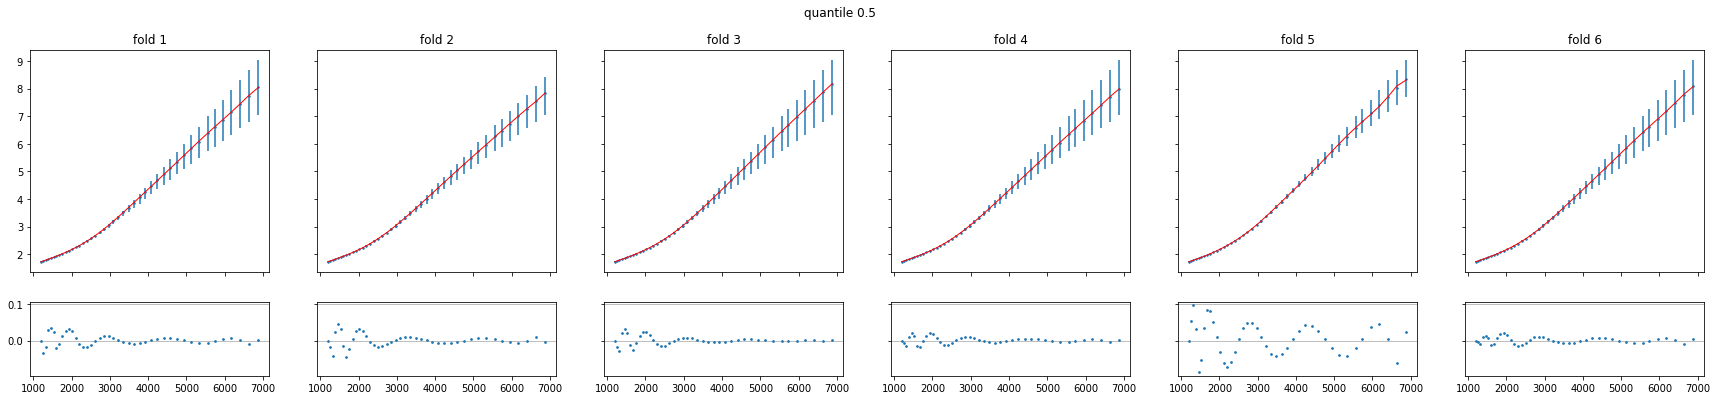

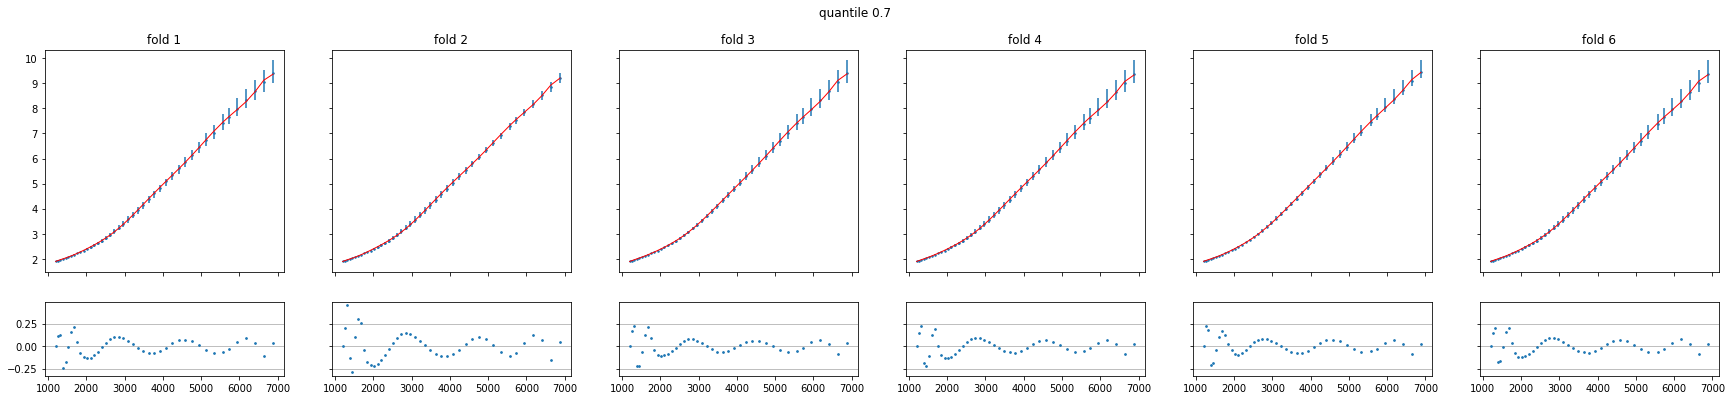

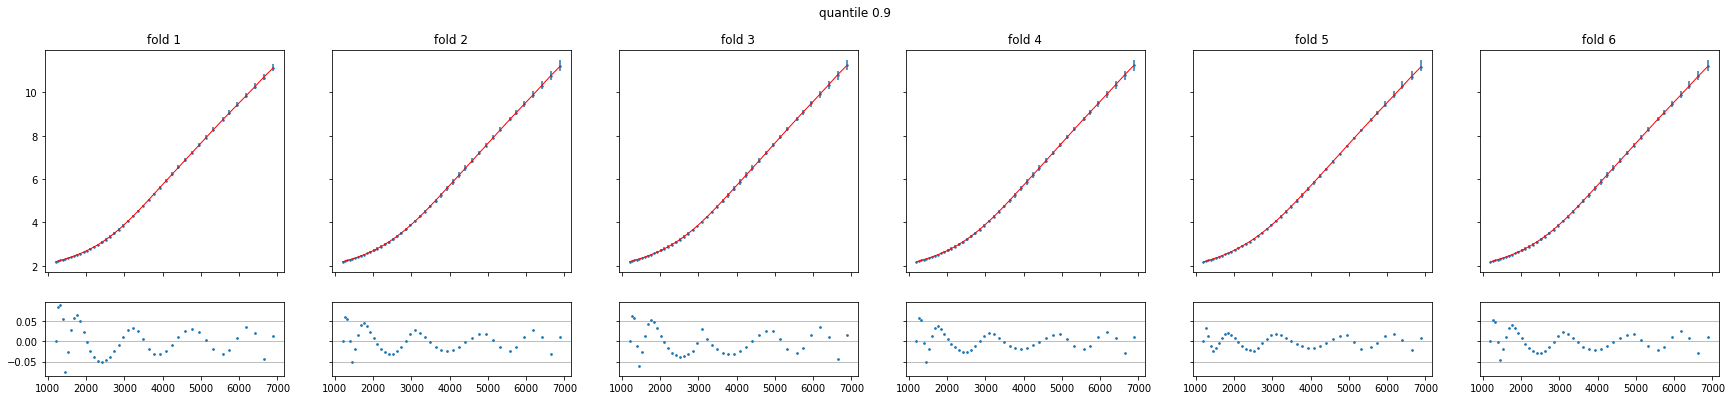

In [98]:
deg = 11
lm_fits_per_fold = compute_lm_fits(deg, envelope_per_fold, quantiles, params, x_shift)
plot_poly_fits(envelope_per_fold, lm_fits_per_fold, quantiles, params, 'lmfit_ord'+str(deg), x_shift)

In [99]:
# write polynomials to file
qr_poly_run_n = out_qr_run_n+3
dapr.write_polynomials_to_json(make_polys_json_path(qr_poly_run_n), lm_fits_per_fold)

writing polynomials to /eos/user/k/kiwoznia/data/QR_results/analysis/vae_run_113/qr_run_46/sig_GtoWW35naReco/xsec_0/loss_rk5_05/envelope_4020/polynomials_allQ_allFolds_GtoWW35naReco_xsec_0.json


# fit output analysis

In [88]:
def goodness_of_lmfit(degrees, uncertainty_fun):
    print('====  chi2 reduced  ====')
    print('degrees:' + '\t'.join(str(d) for d in degrees))

    for k in range(params.kfold_n+1):

        print('fold '+ str(k))    
        envelope = envelope_per_fold['fold_{}'.format(k+1)]

        for qq in quantiles:

            print('quantile {}'.format(qq))

            env_qq = np.asarray(envelope[str(qq)])

            x      = env_qq[:,bin_idx]
            y      = env_qq[:,mu_idx]
            uncert = uncertainty_fun(env_qq)

            chisq = []
            for deg in degrees:
                out = fit_lm(deg, x, y, uncert, x_shift)
                chisq.append(out.redchi)    
            print(np.asarray(chisq))

In [89]:
np.set_printoptions(precision=5, suppress=True,formatter={'float': '{: 0.5f}'.format})
degrees = [5,7,11]

In [91]:
goodness_of_lmfit(degrees, uncertainty_minmax)

====  chi2 reduced  ====
degrees:5	7	11
fold 0
quantile 0.3
[ 0.06478  0.00294  0.00142]
quantile 0.5
[ 0.02135  0.00181  0.00028]
quantile 0.7
[ 0.11061  0.02571  0.01090]
quantile 0.9
[ 0.18023  0.00718  0.00182]
fold 1
quantile 0.3
[ 0.05044  0.00377  0.00143]
quantile 0.5
[ 0.02519  0.00765  0.00038]
quantile 0.7
[ 0.17400  0.06046  0.02825]
quantile 0.9
[ 0.06509  0.00200  0.00081]
fold 2
quantile 0.3
[ 0.08685  0.01093  0.00421]
quantile 0.5
[ 0.01089  0.00234  0.00019]
quantile 0.7
[ 0.09196  0.01868  0.01097]
quantile 0.9
[ 0.09063  0.00347  0.00114]
fold 3
quantile 0.3
[ 0.10873  0.01273  0.00614]
quantile 0.5
[ 0.01733  0.00324  0.00010]
quantile 0.7
[ 0.07501  0.02032  0.01117]
quantile 0.9
[ 0.06466  0.00180  0.00062]
fold 4
quantile 0.3
[ 0.05416  0.00487  0.00152]
quantile 0.5
[ 0.03926  0.00873  0.00256]
quantile 0.7
[ 0.07757  0.01951  0.00958]
quantile 0.9
[ 0.08480  0.00299  0.00027]
fold 5
quantile 0.3
[ 0.05238  0.00427  0.00175]
quantile 0.5
[ 0.01552  0.00236  0.0

In [92]:
# fit quality with yerr uncertainty
goodness_of_lmfit(degrees, uncertainty_yerr)

====  chi2 reduced  ====
degrees:5	7	11
fold 0
quantile 0.3
[ 0.25435  0.01102  0.00506]
quantile 0.5
[ 0.09947  0.00888  0.00123]
quantile 0.7
[ 0.49490  0.12407  0.04535]
quantile 0.9
[ 0.76318  0.03045  0.00733]
fold 1
quantile 0.3
[ 0.20627  0.01509  0.00527]
quantile 0.5
[ 0.10513  0.03144  0.00148]
quantile 0.7
[ 0.70595  0.23576  0.10424]
quantile 0.9
[ 0.27104  0.00860  0.00331]
fold 2
quantile 0.3
[ 0.39334  0.04848  0.01729]
quantile 0.5
[ 0.04486  0.00941  0.00071]
quantile 0.7
[ 0.38967  0.07769  0.04404]
quantile 0.9
[ 0.36299  0.01408  0.00443]
fold 3
quantile 0.3
[ 0.45432  0.05068  0.02355]
quantile 0.5
[ 0.06830  0.01252  0.00038]
quantile 0.7
[ 0.30755  0.08431  0.04388]
quantile 0.9
[ 0.26601  0.00730  0.00239]
fold 4
quantile 0.3
[ 0.22977  0.01988  0.00578]
quantile 0.5
[ 0.17589  0.03868  0.01031]
quantile 0.7
[ 0.37122  0.09696  0.04517]
quantile 0.9
[ 0.37225  0.01302  0.00108]
fold 5
quantile 0.3
[ 0.20972  0.01679  0.00643]
quantile 0.5
[ 0.06590  0.00985  0.0

In [93]:
# fit quality with yerr uncertainty
goodness_of_lmfit(degrees, uncertainty_updown)

====  chi2 reduced  ====
degrees:5	7	11
fold 0
quantile 0.3
[ 0.06478  0.00294  0.00142]
quantile 0.5
[ 0.02135  0.00181  0.00028]
quantile 0.7
[ 0.11061  0.02571  0.01090]
quantile 0.9
[ 0.18023  0.00718  0.00182]
fold 1
quantile 0.3
[ 0.05044  0.00377  0.00143]
quantile 0.5
[ 0.02519  0.00765  0.00038]
quantile 0.7
[ 0.17400  0.06046  0.02825]
quantile 0.9
[ 0.06509  0.00200  0.00081]
fold 2
quantile 0.3
[ 0.08685  0.01093  0.00421]
quantile 0.5
[ 0.01089  0.00234  0.00019]
quantile 0.7
[ 0.09196  0.01868  0.01097]
quantile 0.9
[ 0.09063  0.00347  0.00114]
fold 3
quantile 0.3
[ 0.10873  0.01273  0.00614]
quantile 0.5
[ 0.01733  0.00324  0.00010]
quantile 0.7
[ 0.07501  0.02032  0.01117]
quantile 0.9
[ 0.06466  0.00180  0.00062]
fold 4
quantile 0.3
[ 0.05416  0.00487  0.00152]
quantile 0.5
[ 0.03926  0.00873  0.00256]
quantile 0.7
[ 0.07757  0.01951  0.00958]
quantile 0.9
[ 0.08480  0.00299  0.00027]
fold 5
quantile 0.3
[ 0.05238  0.00427  0.00175]
quantile 0.5
[ 0.01552  0.00236  0.0

In [49]:
degree = 6

In [50]:
ee = np.asarray(envelope_per_fold['fold_1'][str(0.3)])
x = ee[:,bin_idx]
y = ee[:,mu_idx]
uncert = uncertainty_minmax(ee)

In [51]:
x

array([ 1200.00000,  1255.00000,  1320.00000,  1387.00000,  1457.00000,
        1529.00000,  1604.00000,  1681.00000,  1761.00000,  1844.00000,
        1930.00000,  2019.00000,  2111.00000,  2206.00000,  2305.00000,
        2406.00000,  2512.00000,  2620.00000,  2733.00000,  2849.00000,
        2969.00000,  3093.00000,  3221.00000,  3353.00000,  3490.00000,
        3632.00000,  3778.00000,  3928.00000,  4084.00000,  4245.00000,
        4411.00000,  4583.00000,  4760.00000,  4943.00000,  5132.00000,
        5327.00000,  5574.00000,  5737.00000,  5951.00000,  6173.00000,
        6402.00000,  6638.00000,  6882.00000])

In [52]:
y

array([ 1.53950,  1.56860,  1.59987,  1.63053,  1.66308,  1.69865,
        1.73814,  1.78038,  1.82529,  1.87296,  1.92403,  1.97929,
        2.03952,  2.10550,  2.17875,  2.25853,  2.34790,  2.44488,
        2.55247,  2.66897,  2.79528,  2.93119,  3.07633,  3.23020,
        3.39345,  3.56552,  3.74460,  3.93009,  4.12391,  4.32433,
        4.53092,  4.74455,  4.96366,  5.18925,  5.42113,  5.65918,
        5.95899,  6.15587,  6.41326,  6.67909,  6.95221,  7.23265,
        7.52168])

In [53]:
uncert

array([ 0.01348,  0.01000,  0.00739,  0.01033,  0.01547,  0.02240,
        0.03101,  0.04033,  0.04949,  0.05777,  0.06495,  0.07136,
        0.07768,  0.08468,  0.09312,  0.10323,  0.11541,  0.12910,
        0.14419,  0.15973,  0.17507,  0.18943,  0.20209,  0.21248,
        0.22025,  0.22512,  0.22700,  0.22606,  0.22253,  0.21676,
        0.20921,  0.20030,  0.19056,  0.18041,  0.18330,  0.18863,
        0.19714,  0.20591,  0.23174,  0.25877,  0.28681,  0.31578,
        0.34572])

In [54]:
x_shift

1200.0

In [55]:
cc = fit_lm_coeff(degree, x, y, uncert, x_shift)

In [56]:
cc

[3.0419980395583725e-18,
 -3.934357543955583e-14,
 1.4971137904098653e-10,
 -3.765478785089316e-08,
 0.0004900325624486195,
 1.5395013988018036]

In [57]:
pp = np.poly1d(cc)

In [58]:
y_hat = pp(x-x_shift)

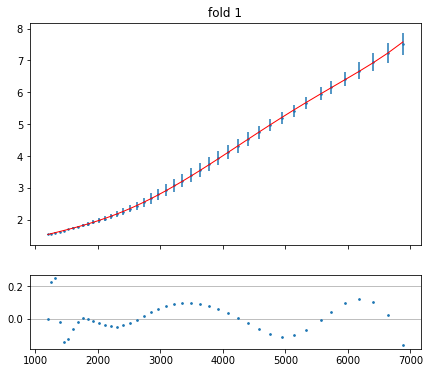

In [59]:
fig, axs = plt.subplots(2,1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax1, ax2 = axs.flat
ax1.errorbar(x, y, yerr=uncert, fmt='o', ms=1.5, zorder=1)
ax1.plot(x, y_hat, c='r',lw=1, zorder=2)
ax1.set_title('fold 1')
            
ax2.plot(x, (y-y_hat)/uncert, 'o', ms=1.7)
ax2.grid(True, which='major', axis='y')
#ax2.set_ylim([0.995,1.005])        

In [61]:
degree = 5
params_lmfit = Parameters()
for d in range(degree-1):
    params_lmfit.add('c'+str(d), value=1)
# add fixed bias value
params_lmfit.add('bias', value=y[0], vary=False)

out = minimize(residual, params_lmfit, args=(x, y, uncert, x_shift))

In [62]:
out

In [63]:
out.redchi

0.06477657165348925

In [64]:
cc = list(out.params.valuesdict().values())

In [65]:
pp = np.poly1d(cc)

In [66]:
y_hat = pp(x-x_shift)

(0.995, 1.005)

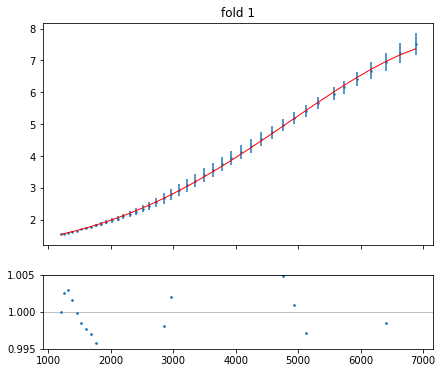

In [67]:
fig, axs = plt.subplots(2,1, figsize=(7,6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
ax1, ax2 = axs.flat
ax1.errorbar(x, y, yerr=uncert, fmt='o', ms=1.5, zorder=1)
ax1.plot(x, y_hat, c='r',lw=1, zorder=2)
ax1.set_title('fold 1')
            
ax2.plot(x, y/y_hat, 'o', ms=1.7)
ax2.grid(True, which='major', axis='y')
ax2.set_ylim([0.995,1.005])        

In [68]:
pp(0)

1.5395013988018036

In [69]:
pp

poly1d([-0.00000,  0.00000,  0.00000,  0.00045,  1.53950])

In [70]:
cc

[-4.399275675905606e-15,
 2.147246682013571e-11,
 1.2140682064253127e-07,
 0.0004492413573637891,
 1.5395013988018036]

In [71]:
out.var_names

['c0', 'c1', 'c2', 'c3']

In [72]:
out.params['bias']

<Parameter 'bias', value=1.5395013988018036 (fixed), bounds=[-inf:inf]>

In [73]:
par = Parameters()
par.add('a', value=1)
par.add('b', value=2)
par.add('f', value=10, vary=False)

In [74]:
par

name,value,initial value,min,max,vary
a,1.00000000,1,-inf,inf,True
b,2.00000000,2,-inf,inf,True
f,10.0000000,10,-inf,inf,False


In [76]:
out = minimize(residual, par, args=(x, y, uncert, x_shift))

In [77]:
out

In [78]:
input_dir_kfold = '/eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_'+str(params.kfold_n)+'fold_signalregion_parts'

In [79]:
from os import listdir

In [80]:
listdir(input_dir_kfold).sort()

In [81]:
files = listdir(input_dir_kfold)

In [82]:
print('reading ' + ' '.join(files))

reading qcd_sqrtshatTeV_13TeV_PU40_NEW_fold1.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold2.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold3.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold4.h5 qcd_sqrtshatTeV_13TeV_PU40_NEW_fold5.h5


In [83]:
def foo(a,*b):
    print('a',a)
    print('b',*b)

In [78]:
def bar(c, *d):
    print('call no star')
    foo(c,d)
    print('call star')
    foo(c,*d)

In [79]:
bar(10,100,1000)

call no star
a 10
b (100, 1000)
call star
a 10
b 100 1000


In [80]:
bar(10,3)

call no star
a 10
b (3,)
call star
a 10
b 3
